# CCLya-Payne Tutorial

Welcome to the **CCLya-Payne** (**C**ode for **C**ontinuous **Ly**man-**a**lpha **P**rofile **A**nal**Y**sis via **N**eural **E**mulation) tutorial! This notebook provides an overview of **CCLya-Payne**, a neural network-based code developed to emulate Lyman-alpha spectra from radiative transfer simulations of a shell model. The tutorial is designed to help you get started with the key features of the code.

### Key Features:
- **Fitting Observed Spectra:**  
   If you're interested in fitting model Lyman-alpha profiles to observed spectra, explore the **fitting** module. It includes tools for optimizing model parameters based on observed data.
   
- **Utilities for Spectrum Generation and Plotting:**  
   The **utils** module contains useful functions for both the fitting process and for generating Lyman-alpha spectra. You can also use these functions to visualize the spectra.

- **Training the Neural Network:**  
   To train the neural network on your own simulated spectra, refer to the **training** module. This section of the code allows you to customize the model training process with your dataset.

**Note:** If you wish to change between the two available neural networks, one trained on spectra convolved with an LSF with FWHM = 10 km/s (`cclya_neuralnetwork.npz`) and one trained on raw (`cclya_neuralnetwork_raw.npz`) spectra, you will need to go to the **utils** module and change the call to the different neural networks (see README.md for further notes).

Feel free to explore the code, and don’t hesitate to experiment with the examples provided in each section to deepen your understanding of the CCLya-Payne workflow!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Append sys path
import sys
sys.path.append('/Users/eriksolhaug/Research/Tools/CCLya-Payne') # Add your own path here!

import utils
import fitting

### Producing a Lyman-alpha profile

One can plot a Lyman-alpha profile produced by the neural network as follows.

When using the `get_model()` function, you can specify these parameters:

- **$\sigma_{\mathrm{int}}$**: Intrinsic velocity dispersion of the emitting source.
- **$\log(N_{\mathrm{HI}})$**: Column density of the neutral hydrogen shell.
- **$v_{\mathrm{exp}}$**: Outflow/inflow velocity of the shell (negative values indicate inflow).
- **$\log(T)$**: Effective temperature of the shell.

To access the x-values for the spectrum, use `load_wavelength_array()`. These values are in velocity space, relative to the Lyman-alpha rest-frame wavelength.


Figure saved successfully as ./outputs/lya_profile.pdf


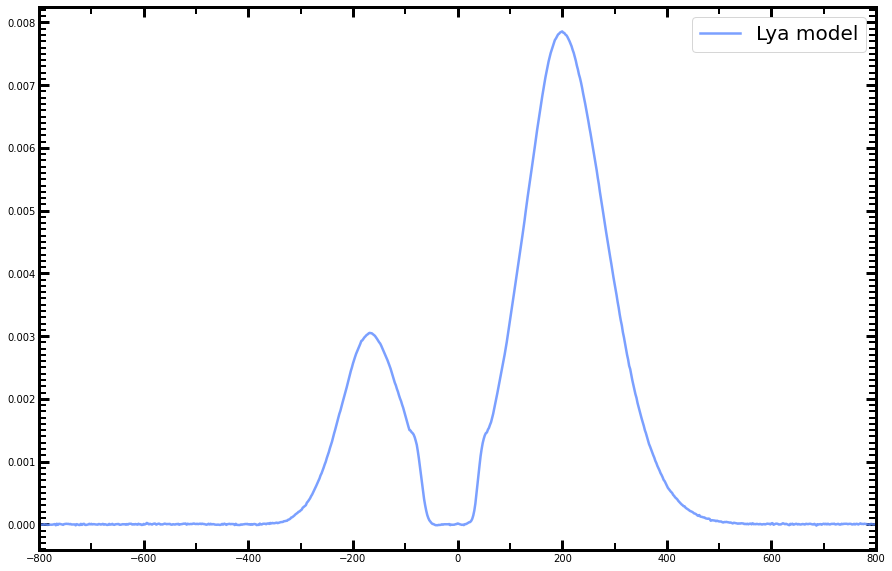

In [2]:
wavelength = utils.load_wavelength_array()
lya_y = utils.get_model(30., 19.8, 20., 4.2)
fig, ax = utils.plot_lya(wavelength, lya_y, outfile='./outputs/lya_profile.pdf')

### Load and compare with training spectra

To load the training and validation data for the neural network, use the `load_training_data()` function. This will return four arrays:

- **`training_labels`**: Contains the physical parameter labels (e.g., $\sigma_{\mathrm{int}}$, $\log(N_{\mathrm{HI}})$) for the training set.
- **`training_spectra`**: Contains the simulated Lyman-alpha spectra used for training the neural network.
- **`validation_labels`**: Provides the physical parameter labels for the validation set, used to assess the model’s performance.
- **`validation_spectra`**: Contains the corresponding Lyman-alpha spectra for the validation set.

In [3]:
training_labels, training_spectra, validation_labels, validation_spectra = utils.load_training_data()

To retrieve and compare the raw training spectra with the spectra produced by the neural network, you can use the `find_training_spectrum()` function. This function allows you to search for the raw training spectrum that corresponds to specific physical parameters.

In this case, the input `[30., 19.8, 20., 4.2]` represents a specific set of parameters (e.g., $\sigma_{\mathrm{int}}$, $\log(N_{\mathrm{HI}})$, etc.) used in the training. The resulting spectrum is then plotted alongside the neural network’s output, allowing for a direct comparison.


Figure saved successfully as ./outputs/lya_profile.pdf


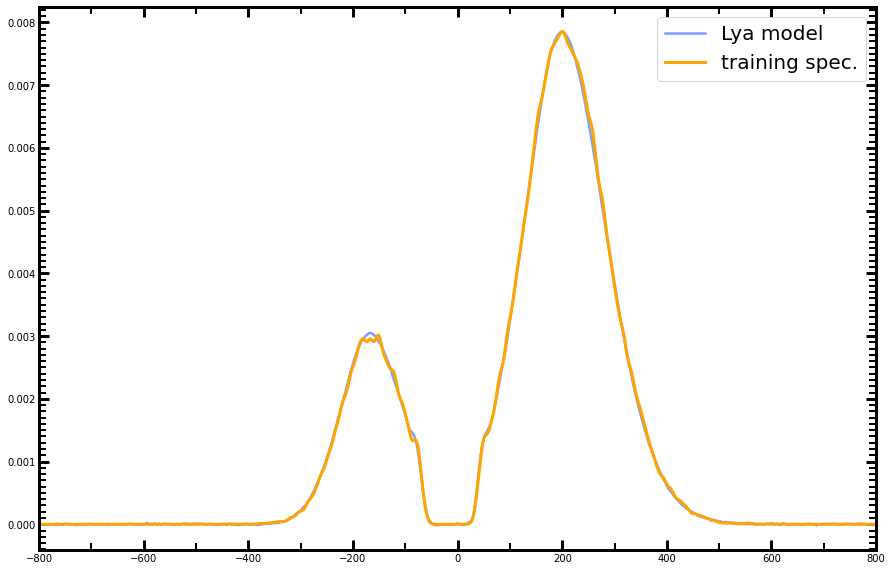

In [4]:
training_y = utils.find_training_spectrum([  30. ,   19.8,  20. ,    4.2], training_labels, training_spectra, validation_labels, validation_spectra)[0]

fig, ax = utils.plot_lya(wavelength, lya_y, train_x=wavelength, train_y=training_y, outfile='./outputs/lya_profile.pdf')

As we can see, the raw spectra, consisting of $10^5$ photons, contain some Poisson noise. The neural network does a good job of capturing the main features of the Lyman-alpha profiles while ignoring the noisy fluctuations.


### Fitting an observed Lyman-alpha spectrum

One can also fit an observed spectrum using the MCMC process included in the `CCLya-Payne` code, available in the `fitting.py` package.

In this example, we use a sample spectrum, which is the same training spectrum from above with added Gaussian noise. The fitting code is able to fit the Lyman-alpha profile and recover the empirical parameters, along with their $1\,\sigma$ error bars.

**Note:** Before performing a fit, you should modify the parameter guesses and priors in the `guess.txt` and `prior.txt` files. To help with this, you can use the `get_model()` and `plot_lya()` functions from the `utils.py` module to overlay Lyman-alpha profiles on your observed spectra. This will give you an idea of good guesses to include in the `guess.txt` file and appropriate parameter ranges for the `prior.txt` file. The fitting code will automatically calculate the normalization parameter, $A_{\mathrm{Lya}}$, for the best-fit profile. Be sure to set the parameters in the exact order specified in `guess.txt` and `prior.txt` to avoid errors.

In [ ]:
# Read in sample spectrum
obsspec_path = './data/sample_spectrum.csv'
obs_x, obs_y, obs_err = np.loadtxt(obsspec_path, delimiter=',', skiprows=1, unpack=True)

# Perform fit to observed spectrum
fitting.fit_lya(obs_x=obs_x, obs_y=obs_y, obs_err=obs_err, num_walkers=500, num_steps=500, discard=50, thin=5, save_dir="./mcmc")

Guess:  [20.  19.7 39.   4.6  0. ]
Booting MCMC...


 39%|███▊      | 193/500 [11:58<17:57,  3.51s/it]

After running the fit, you can find the output files in the `./mcmc` directory:

- **`priorplotX.pdf`**: Visualization of the initialization of the walkers within the (flat) prior distribution. The X corresponds to the parameter number in the order of the parameter input specified earlier and in the guess.txt.
- **`output_model.csv`**: Contains the x- and y-arrays of the best-fit model.
- **`progress.pdf`**: Shows the progress of the MCMC sampling for all parameters.
- **`cornerplot.pdf`**: Provides a corner plot displaying the MCMC results for each parameter.
- **`results.csv`**: Lists the best-fit parameters along with their lower and upper error bounds. For example, `sigma_int = 20, sigma_int_lower = 2, sigma_int_upper = 3` indicates a best-fit intrinsic dynamics parameter of 20 km/s with a 1-sigma uncertainty of -2 km/s and +3 km/s.
- **`chi2.txt`**: Contains the calculated chi-squared value and chi-squared per degree of freedom (`chi2_dof = chi2 / dof`).
- **`plot.pdf`**: Is a plot of the best-fit model on top of the observed spectrum.
- **`backend.txt`, `sampler.txt`, `samples.txt`, `flatsamples.txt`**: Stores the MCMC backend, sampler and the collected samples.

To run a faster, though potentially less accurate, MCMC fitting process, reduce the values of the `num_walkers` and `num_steps` parameters. You may also need to adjust the `discard` and `thin` parameters to control how many initial steps are ignored (burn-in) and how frequently samples are saved, respectively. Lower values for these parameters can speed up the fitting process, but may compromise accuracy, so balance these settings based on your computational resources and desired precision.

### Identifying Underfitting and Overfitting

Both the default neural network (`cclya_neuralnetwork.npz`) and the raw neural network (`cclya_neuralnetwork_raw.npz`) are trained on $330{,}803$ Lyman-alpha profiles produced with the radiative transfer code TLAC.

To assess the neural network's performance and check for overfitting or underfitting, you can plot the loss for the training and validation spectra separately. The following code will help you visualize this:

In [ ]:
training_loss, validation_loss = utils.get_loss()

plt.figure(figsize=(14, 6))
# Multiply x-axis values by 100 to get the training step. In fitting.py, the loss is only saved every 100 steps.
# Divide y-axis values by 1e4 because in fitting.py the loss is multiplied by this factor before being saved.
plt.plot(np.arange(training_loss.size)*100, training_loss/1e4, 'k', linewidth=2, label = 'Training set')
plt.plot(np.arange(validation_loss.size)*100, validation_loss/1e4, 'r', linewidth=2, linestyle='--', color='magenta', label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 18)
plt.yscale('log')
plt.xlabel("Step", size=20)
plt.ylabel("Loss", size=20)

- The neural network is **underfitting** if the loss of both the training set and the validation set are high, and the validation loss decreases more slowly than the training loss, or remains high even as the training loss decreases. This occurs when the model is too simple to capture the underlying patterns in the data.

- The neural network is **overfitting** if the loss of the training set decreases significantly while the loss of the validation remains high after initially decreasing. This happens when the model performs very well on the training set but poorly on the validation set.

- If the loss of the training set and the validation set decrease at a similar rate and both reach a low, stable value, then the neural network is neither underfitting nor overfitting.

### Next Steps

If you wish to train the neural network on your own spectra or adjust parameters such as the number of neurons, learning rate, etc., you may want to look into `training.py` and modify your code and training spectra accordingly.

### Author Notes and Acknowledgments

This tutorial and the accompanying code were written by Erik Solhaug (ES).

For any questions or feedback, please contact Erik Solhaug at eriksolhaug at uchicago dot edu.

The **fitting** and **radam** module, along with certain functions in the **utils** module (read_in_neural_network, leaky_relu, get_spectrum_from_neural_net, load_training_data, get_loss), are adapted from **The Payne** developed by Ting et al. (2019, [ApJ 879, 69](https://ui.adsabs.harvard.edu/abs/2019ApJ...879...69T/abstract)), which originally fit stellar atmosphere spectra using a neural network approach. The modifications in this repository have been tailored to fit Lyα spectra. The synthetic spectra used for training the neural network were generated using the **TLAC** radiative transfer code by Gronke and Dijkstra (2014, [MNRAS 444, 1095](https://ui.adsabs.harvard.edu/abs/2014MNRAS.444.1095G/abstract)).

### Current Version Number

- **CCLya Version 1.1:** Last updated September 12th, 2024 by ES. Tutorial updated September 12th, 2024.